# Проект "Исследование маркетинговых затрат Яндекс.Афиши"

## Описание исследования:
Перед отделом аналитики Яндекс.Афиши стоит задача оптимизировать маркетинговые расходы. Для анализа предоставленны данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года, включая логи сервера, выгрузку всех заказов, статистику рекламных расходов.

## Задачи исследования:
* Изучить, как люди пользуются продуктом.
* Выяснить, когда пользователи начинают покупать.
* Оценить, сколько денег приносит каждый клиент.
* Оценить, сколько времени нужно, чтобы клиент начал окупаться.

## План исследования:
1. Ознакомиться с предоставленными данными.
2. Провести предобработку данных.
3. Оценить имеющиеся для анализа показатели и, в случае необходимости, добавить новые.
4. Построить отчёты и посчитать метрики.
5. Сформулировать выводы по итогам проведенного анализа.

## <a name="table_of_contents"></a> Структура проекта:
* 1. [Предобработка данных](#preprocessing)
    * 1.1. [Ознакомление с данными](#first_sight)
    * 1.2. [Изменение типов данных](#data_type_change)
* 2. [Отчёты и метрики](#reports_and_metrics)
    * 2.1. [Метрики продукта](#product)
        * 2.1.1. [Метрики DAU, WAU, MAU](#dau_wau_mau)
        * 2.1.2. [Количество пользователей для различных каналов и платформ](#users_by_device_and_source)
        * 2.1.3. [Количество сессий в день](#session_per_day)
        * 2.1.4. [Продолжительность одной сессии](#session_duration)
        * 2.1.5. [Retention Rate](#retention_rate)
    * 2.2. [Отчёты по продажам](#sales)
        * 2.2.1. [Время от визита до покупки](#first_purchase)
        * 2.2.2. [Количество покупок в день, неделю, месяц](#purchase_by_period)
        * 2.2.3. [Средний чек](#average_bill)
        * 2.2.4. [Livetime Value](#ltv)
    * 2.3. [Маркетинговые метрики](#marketing)
        * 2.3.1. [Анализ маркетинговых расходов](#costs_analysis)
        * 2.3.2. [Стоимость привлечения пользователей](#cac)
        * 2.3.3. [Коэффициент окупаемости](#roi)
* 3. [Общий вывод](#conclusion)
    * 5.1. [Обзор проведенного анализа](#what_was_done)
    * 5.2. [Главные выводы](#main_conclusions)
    * 5.3. [Рекомендации](#recommendations)

## <a name="preprocessing"></a> Предобработка данных

### <a name="first_sight"></a> Ознакомление с данными

#### Описание переменных
Набор данных `visits` - содержит логи сервера с информацией о посещениях сайта. Переменные:
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Набор данных `orders` - содержит информацию о заказах. Переменные:
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Набор данных `costs` - содержит информацию о заказах. Переменные:
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Улучшение качества отображения графиков
%config InlineBackend.figure_format = 'retina'

# Стиль графиков
sns.set_style('whitegrid')

# Количество знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# Обработка предупреждений при построении графиков с датами
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Начнем с набора данных `visits`.

In [3]:
# Датасет с логами сервера
path = 'visits_log.csv'
df_visits = pd.read_csv(path)

In [4]:
# Общая информация о таблице
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
# Посмотрим на 10 случайных строк из таблицы
df_visits.sample(10)

,Device,End Ts,Source Id,Start Ts,Uid
210851,desktop,2017-12-15 11:09:00,2,2017-12-15 11:06:00,9283162666231078747
69458,desktop,2018-02-05 15:40:00,1,2018-02-05 15:21:00,1594358396677071983
133873,desktop,2018-04-26 23:55:00,2,2018-04-26 23:26:00,11927151411991110714
309857,desktop,2018-03-23 08:29:00,5,2018-03-23 08:18:00,10003889359766168715
345286,touch,2018-02-17 16:15:00,1,2018-02-17 16:07:00,2903157372889561099
24787,touch,2018-01-11 00:21:00,5,2018-01-10 23:44:00,9523945569560890163
235167,desktop,2018-02-21 10:07:00,5,2018-02-21 10:01:00,14907608505136455362
94527,desktop,2018-05-10 14:11:00,1,2018-05-10 13:55:00,8892554312971410216
346474,desktop,2017-10-07 07:29:00,3,2017-10-07 07:26:00,17469489408471292492
125005,desktop,2017-10-16 10:24:00,3,2017-10-16 10:19:00,431188048004283537


In [6]:
# Проверим датасет на дубликаты
df_visits.duplicated().sum()

0

#### Вывод по датасету `df_visits`:
- В данных отсутствуют пропуски и дубликаты.
- Названия столбцов следует привести к нижнему регистру и убрать пробелы.
- Данные в столбцах `End Ts` и `Start Ts` необходимо привести к формату даты и времени.

##### Посмотрим на набор данных `orders`.

In [7]:
# Датасет с информацией о заказах
path = 'orders_log.csv'
df_orders = pd.read_csv(path)

In [8]:
# Общая информация о таблице
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
# Посмотрим на 10 случайных строк из таблицы
df_orders.sample(10)

,Buy Ts,Revenue,Uid
20128,2017-11-25 19:31:00,0.12,820157239640600373
20193,2017-11-25 22:23:00,2.99,13579570694593168354
24990,2017-12-20 00:33:00,2.75,2694912891205652776
16427,2017-11-06 23:28:00,2.67,2586859811351390631
9446,2017-09-28 12:23:00,2.14,11498281268106040071
4241,2017-07-23 10:12:00,1.83,8274177229306162777
31316,2018-01-27 12:58:00,1.22,16645026244325278389
6195,2017-08-28 13:42:00,6.11,8377930635019977539
1265,2017-06-11 14:50:00,2.20,6452317594310794486
30561,2018-01-22 21:21:00,7.87,6217689003130979926


In [10]:
# Проверим датасет на дубликаты
df_orders.duplicated().sum()

0

#### Вывод по датасету `df_orders`:
- В данных отсутствуют пропуски и дубликаты.
- Названия столбцов следует привести к нижнему регистру и убрать пробелы.
- Данные в столбце `Buy Ts` необходимо привести к формату даты и времени.

##### Посмотрим на набор данных `costs`.

In [11]:
# Датасет с информацией о заказах
path = 'costs.csv'
df_costs = pd.read_csv(path)

In [12]:
# Общая информация о таблице
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [13]:
# Посмотрим на 10 случайных строк из таблицы
df_costs.sample(10)

,source_id,dt,costs
2507,10,2018-04-27,18.68
1847,9,2017-07-02,6.60
1259,4,2017-11-18,312.73
2183,10,2017-06-05,26.68
84,1,2017-08-24,33.88
2267,10,2017-08-28,11.66
1481,5,2017-06-30,77.88
1607,5,2017-11-03,186.36
41,1,2017-07-12,53.53
754,3,2017-06-29,103.47


In [14]:
# Проверим датасет на дубликаты
df_costs.duplicated().sum()

0

#### Вывод по датасету `df_costs`:
- В данных отсутствуют пропуски и дубликаты.
- Данные в столбце `dt` необходимо привести к формату даты.

[Вернуться к оглавлению](#table_of_contents)

### <a name="data_type_change"></a> Изменение типов данных

#### Датасет `df_visits`

In [15]:
# Список имён столбцов
df_visits.columns.to_list()

['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']

In [16]:
# Приведем названия столбцов с нижнему регистру и избавимся от пробелов
df_visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

# Проверим результат
df_visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [17]:
# Изменим тип данных в столбцах end_ts и start_ts
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

# Проверим результат
df_visits.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

#### Датасет `df_orders`

In [18]:
# Список имён столбцов
df_orders.columns.to_list()

['Buy Ts', 'Revenue', 'Uid']

In [19]:
# Приведем названия столбцов с нижнему регистру и избавимся от пробелов
df_orders.columns = ['buy_ts', 'revenue', 'uid']

# Проверим результат
df_orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [20]:
# Изменим тип данных в столбце buy_ts
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

# Проверим результат
df_orders.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

#### Датасет `df_costs`

In [21]:
df_costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [22]:
# Изменим тип данных в столбце buy_ts
df_costs['dt'] = pd.to_datetime(df_costs['dt'], format = '%Y-%m-%d')

# Проверим результат
df_costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

### Результаты изменения типов данных:
В целом, данные достаточно чистые. В набор данных внесены незначительные изменения:
1. Названия столбцов приведены к нижнему регистру.
2. Даты приведены к соответствующим форматам.

[Вернуться к оглавлению](#table_of_contents)

## <a name="reports_and_metrics"></a> Отчёты и метрики

### <a name="product"></a> Метрики продукта

#### В данном разделе исследования нужно ответить на следующие вопросы:
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

####  <a name="dau_wau_mau"></a> Метрики DAU, WAU, MAU

In [23]:
# Добавим новые столбцы для расчёта DAU, WAU, MAU
df_visits['session_date'] = df_visits['start_ts'].dt.date
df_visits['session_dayofweek'] = df_visits['start_ts'].dt.dayofweek
df_visits['session_week']  = df_visits['start_ts'].dt.week
df_visits['session_month'] = df_visits['start_ts'].dt.month
df_visits['session_year'] = df_visits['start_ts'].dt.year

In [24]:
# Рассчитаем нужные метрики
dau_total = df_visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = df_visits.groupby('session_week').agg({'uid': 'nunique'}).mean()
mau_total = df_visits.groupby('session_month').agg({'uid': 'nunique'}).mean()

print("Количество уникальных пользователей в день: {0:.2f}".format(dau_total[0]))
print("Количество уникальных пользователей в неделю: {0:.2f}".format(wau_total[0]))
print("Количество уникальных пользователей в месяц: {0:.2f}".format(mau_total[0]))

Количество уникальных пользователей в день: 907.99
Количество уникальных пользователей в неделю: 5825.29
Количество уникальных пользователей в месяц: 23228.42


In [25]:
# Рассчитаем sticky factor для оценки лояльности пользователей
sf_wau = (dau_total / wau_total) * 100
sf_mau = (dau_total / mau_total) * 100

print("Sticky Factor за неделю: {0:.2f}".format(sf_wau[0]))
print("Sticky Factor за месяц: {0:.2f}".format(sf_mau[0]))

Sticky Factor за неделю: 15.59
Sticky Factor за месяц: 3.91


####  <a name="users_by_device_and_source"></a> Количество пользователей для различных каналов и платформ

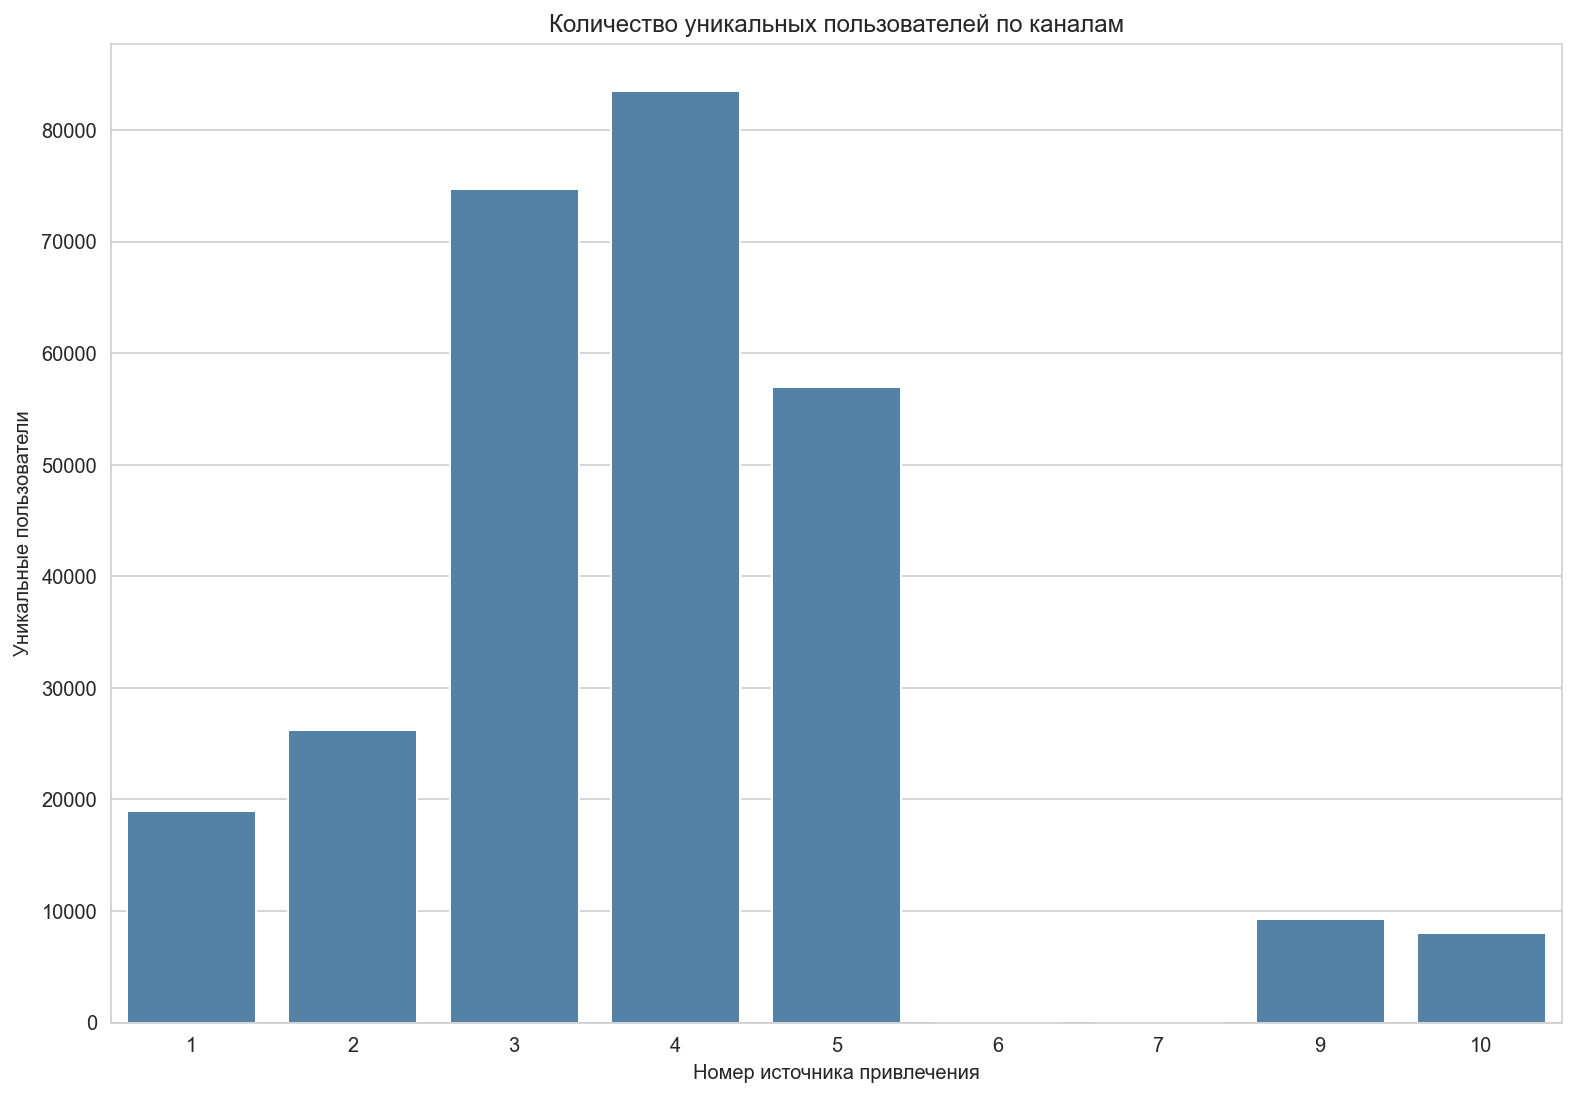

In [26]:
# Найдем среднее количество уникальных пользователей по источникам
df_visits_by_source = df_visits.groupby('source_id').agg({'uid': 'nunique'}).reset_index()

# Построим график
plt.figure(figsize = (13, 9))
plt.title('Количество уникальных пользователей по каналам')
ax = sns.barplot(x="source_id", y="uid", data=df_visits_by_source, color='steelblue')
# ax.set_xticklabels(month_list, rotation=45)
plt.xlabel('Номер источника привлечения')
plt.ylabel('Уникальные пользователи')
plt.show()

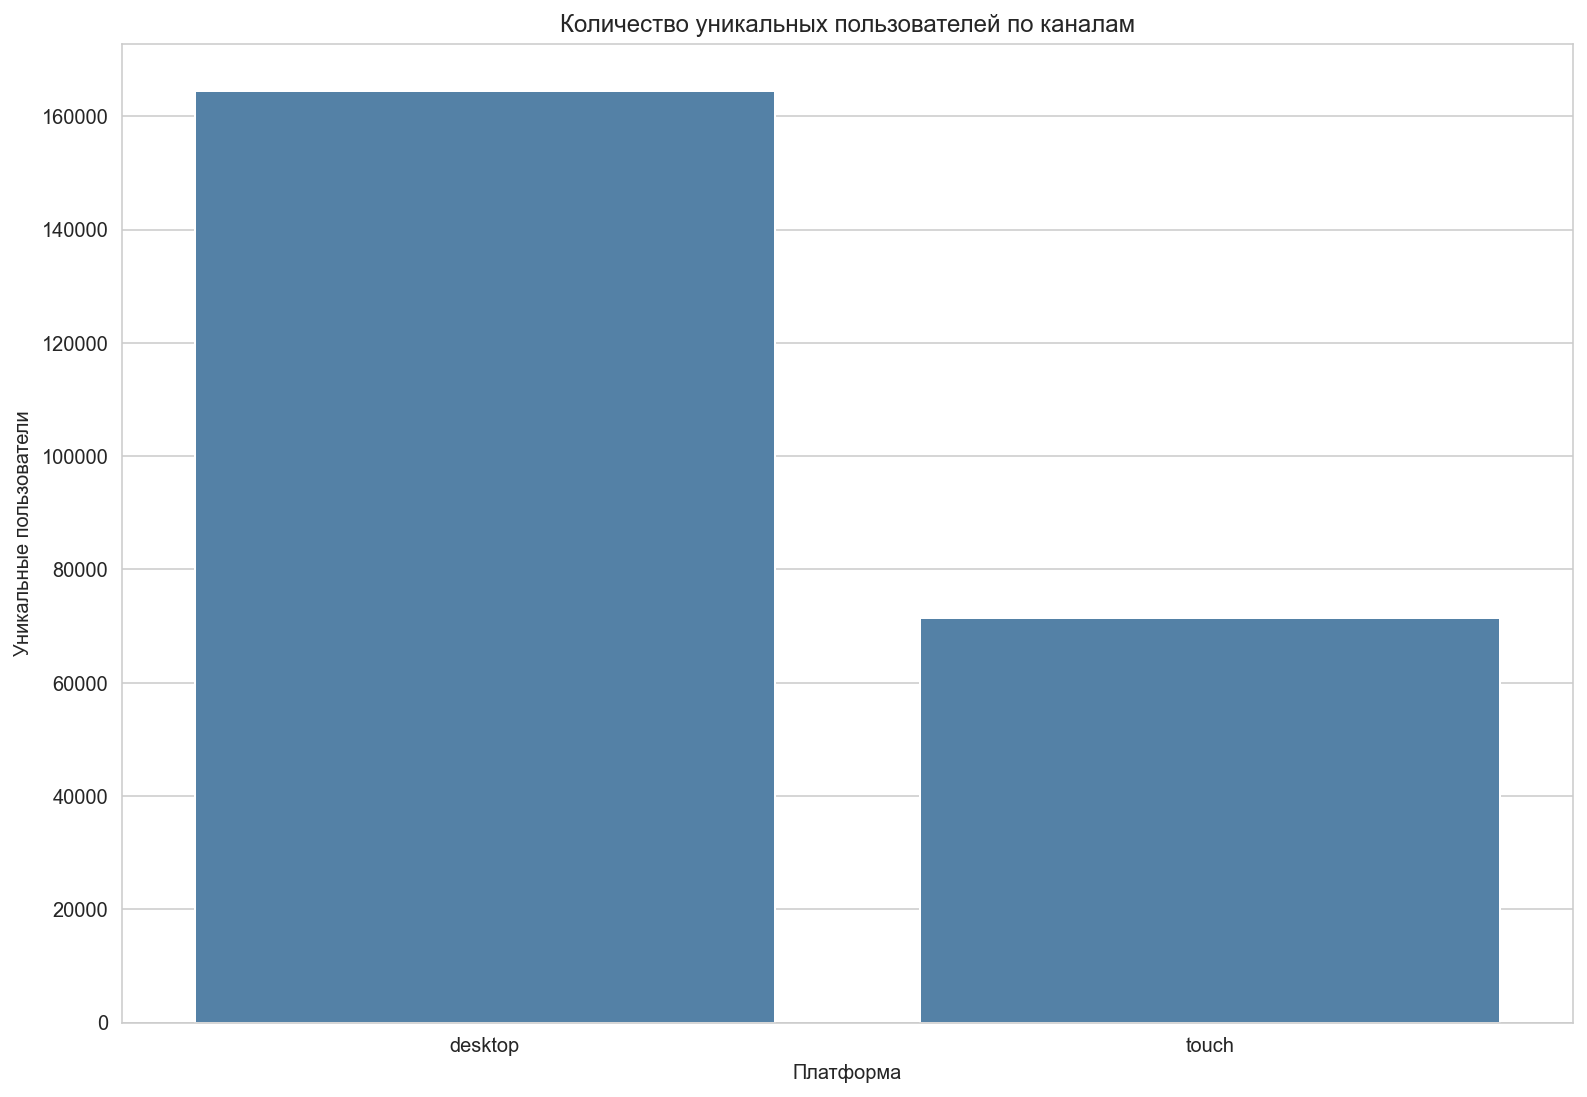

In [27]:
# Найдем среднее количество уникальных пользователей по платформам
df_visits_by_device = df_visits.groupby('device').agg({'uid': 'nunique'}).reset_index()

# Построим график
plt.figure(figsize = (13, 9))
plt.title('Количество уникальных пользователей по каналам')
ax = sns.barplot(x="device", y="uid", data=df_visits_by_device, color='steelblue')
# ax.set_xticklabels(month_list, rotation=45)
plt.xlabel('Платформа')
plt.ylabel('Уникальные пользователи')
plt.show()

#### Вывод:
1. Пользователи не слишком активно пользуются сервисом Яндекс.Афиша, среднее количество уникальных пользователей в день не превышает тысячи. Показатели Sticky Factor также говорят о низкой лояльности пользователей.
2. Больше всего пользователей пришли из источника №4.
3. Большинство пользователей пользуются сервисом с помощью ПК, а не с помощью смартфонов и планшетов.

####  <a name="session_per_day"></a> Количество сессий в день

In [28]:
session_count = df_visits.groupby('session_date').agg({'uid': 'count'}).mean()
print("Количество сессий в день {0:.2f}".format(session_count[0]))

Количество сессий в день 987.36


#### Вывод:
Количество сессий в день говорит о том, что практически все пользователи проводят в день не более одной сессии.

#### <a name="session_duration"></a> Продолжительность одной сессии

In [29]:
# Найдем продолжительность всех сессий
df_visits['session_duration_sec'] = (df_visits['end_ts'] - df_visits['start_ts']).dt.seconds

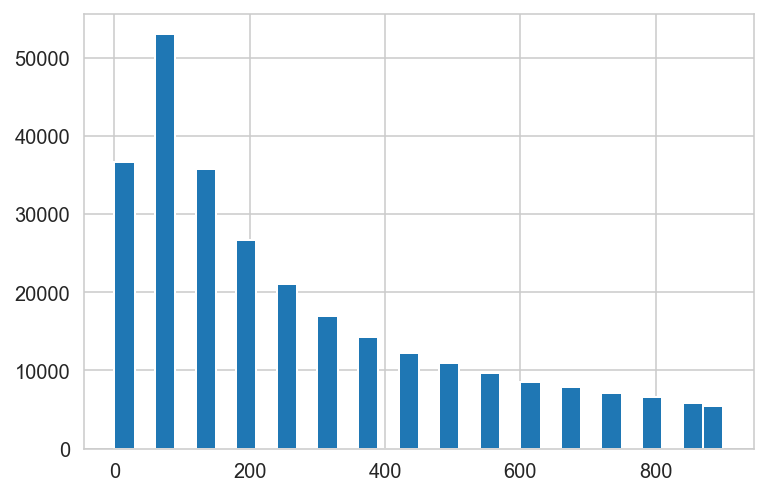

In [30]:
# Посмотрим на распределение продолжительности сессий
df_visits['session_duration_sec'].hist(bins=30, range=(0,900))
plt.show()

In [31]:
df_visits['session_duration_sec'].describe()

count   359,400.00
mean        643.51
std       1,016.33
min           0.00
25%         120.00
50%         300.00
75%         840.00
max      84,480.00
Name: session_duration_sec, dtype: float64

##### Распределение не симметричное, поэтому вместо среднего используем моду для описания стандартной сессии.

In [32]:
print("Средняя продолжительность сессии {0} секунд.".format(df_visits['session_duration_sec'].mode()[0]))

Средняя продолжительность сессии 60 секунд.


#### Вывод:
Средняя сесссия длится всего 60 секунд - довольно мало, если предположить, что пользователи используют Яндекс.Афишу для поиска информации о мероприятиях.

####  <a name="retention_rate"></a> Retention Rate

In [33]:
# Рассчитаем Retention Rate для ответа на этот вопрос
# Сначала найдем дату первой активности для каждого пользователя
first_visit_date = df_visits.groupby('uid')['start_ts'].min().reset_index()

# Переименуем названия столбцов
first_visit_date.columns = ['uid', 'first_visit']

# Результат
first_visit_date.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [34]:
# Объединим датафреймы
df_visits = df_visits.merge(first_visit_date, on='uid')

# Посмотрим на результат объединения
df_visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_dayofweek,session_week,session_month,session_year,session_duration_sec,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2,51,12,2017,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,0,8,2,2018,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,26,7,2017,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,6,20,5,2018,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,4,10,3,2018,1680,2018-03-09 20:05:00


In [35]:
# Сформируем когорты с периодом 1 месяц
df_visits['visit_month'] = df_visits['start_ts'].astype('datetime64[M]')
df_visits['first_visit_month'] = df_visits['first_visit'].astype('datetime64[M]')

df_visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_dayofweek,session_week,session_month,session_year,session_duration_sec,first_visit,visit_month,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,0,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,6,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,4,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01


In [36]:
# Найдем lifetime для каждой когорты
df_visits['cohort_lifetime'] = (df_visits['visit_month'] - df_visits['first_visit_month']) / np.timedelta64(1,'M')
df_visits['cohort_lifetime'] = df_visits['cohort_lifetime'].round().astype('int')

In [37]:
# Найдем количество активных пользователей для каждой когорты на определенную "неделю жизни"
cohorts = df_visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

In [38]:
# Найдем изначальное число пользователей в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]

# Переименуем столбец
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [39]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')

In [40]:
# Рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

# Построим сводную таблицу
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,nan
2017-08-01,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,nan,nan
2017-09-01,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,nan,nan,nan
2017-10-01,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,nan,nan,nan,nan
2017-11-01,1.00,0.08,0.04,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan
2017-12-01,1.00,0.06,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan,nan
2018-01-01,1.00,0.06,0.04,0.02,0.02,nan,nan,nan,nan,nan,nan,nan
2018-02-01,1.00,0.06,0.03,0.02,nan,nan,nan,nan,nan,nan,nan,nan


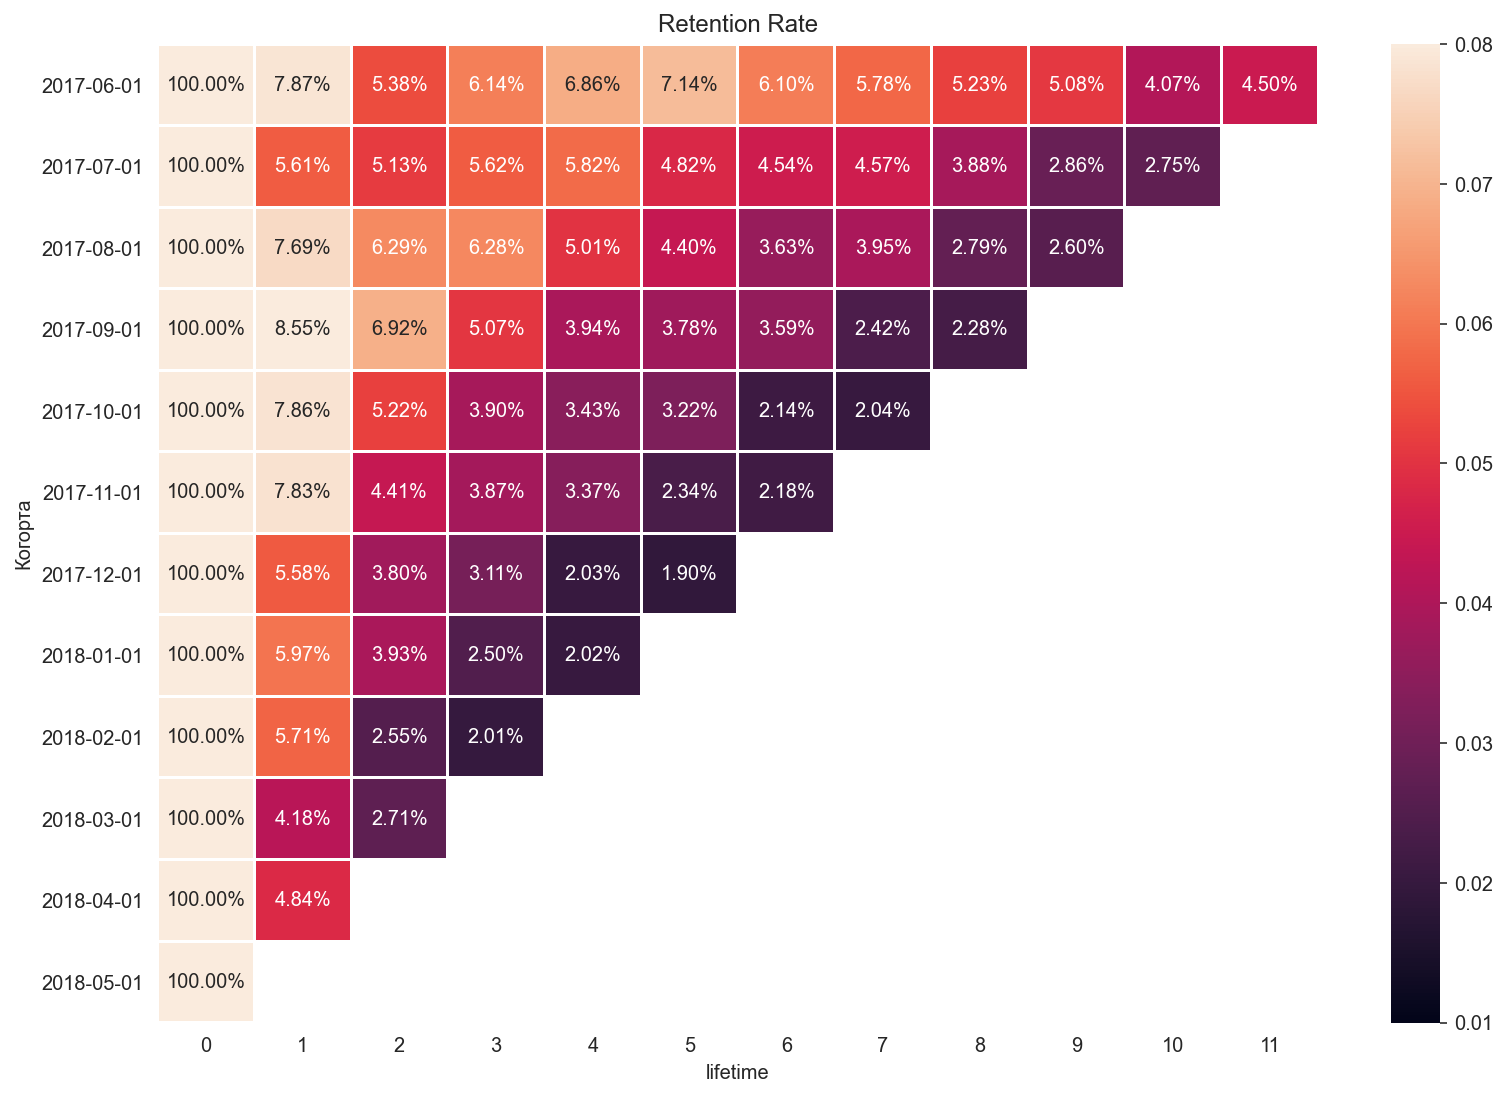

In [41]:
# Построим график heatmap
plt.figure(figsize = (13, 9))
plt.title('Retention Rate')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='white', vmin = 0.01, vmax=0.08)
ax.set_yticklabels(retention_pivot.index.date)
plt.xlabel('lifetime')
plt.ylabel('Когорта')
plt.show()

[Вернуться к оглавлению](#table_of_contents)

### <a name="sales"></a> Отчёты по продажам

#### В данном разделе исследования нужно ответить на следующие вопросы:
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

#### <a name="first_purchase"></a> Время от визита до покупки

In [42]:
# Создадим новый датафрейм с датой первого посещения для каждого пользователя
df_first_visit = df_visits.groupby('uid').agg({'start_ts': 'min'}).rename(columns={'start_ts': 'first_visit'}).reset_index()

In [43]:
# Создадим новый датафрейм с датой первого заказа для каждого пользователя
df_first_order = df_orders.groupby('uid').agg({'buy_ts': 'min'}).rename(columns={'buy_ts': 'first_order'}).reset_index()

In [44]:
# Объединим данные в новый датафрейм
df_purchase = df_first_visit.merge(df_first_order, on='uid', how='inner')

In [45]:
df_purchase.head()

,uid,first_visit,first_order
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [46]:
# Найдем время, которое проходит между первым визитом и покупкой
df_purchase['time_to_purchase'] = (df_purchase['first_order'] - df_purchase['first_visit']) / np.timedelta64(60,'s')

In [47]:
df_purchase.sample(5)

,uid,first_visit,first_order,time_to_purchase
11029,5548577057860708833,2018-05-18 09:53:00,2018-05-18 10:27:00,34.00
35419,17881789259136791553,2017-10-06 14:26:00,2017-12-02 17:20:00,"82,254.00"
19080,9656855858056749327,2017-08-02 00:01:00,2017-08-02 00:02:00,1.00
13090,6536572129778837729,2018-05-30 11:14:00,2018-05-30 11:14:00,0.00
5187,2627773194205774482,2018-01-28 20:01:00,2018-01-31 22:59:00,"4,498.00"


In [48]:
df_purchase['time_to_purchase'].describe()

count    36,523.00
mean     24,340.18
std      67,784.77
min           0.00
25%           4.00
50%          16.00
75%       2,897.00
max     523,144.00
Name: time_to_purchase, dtype: float64

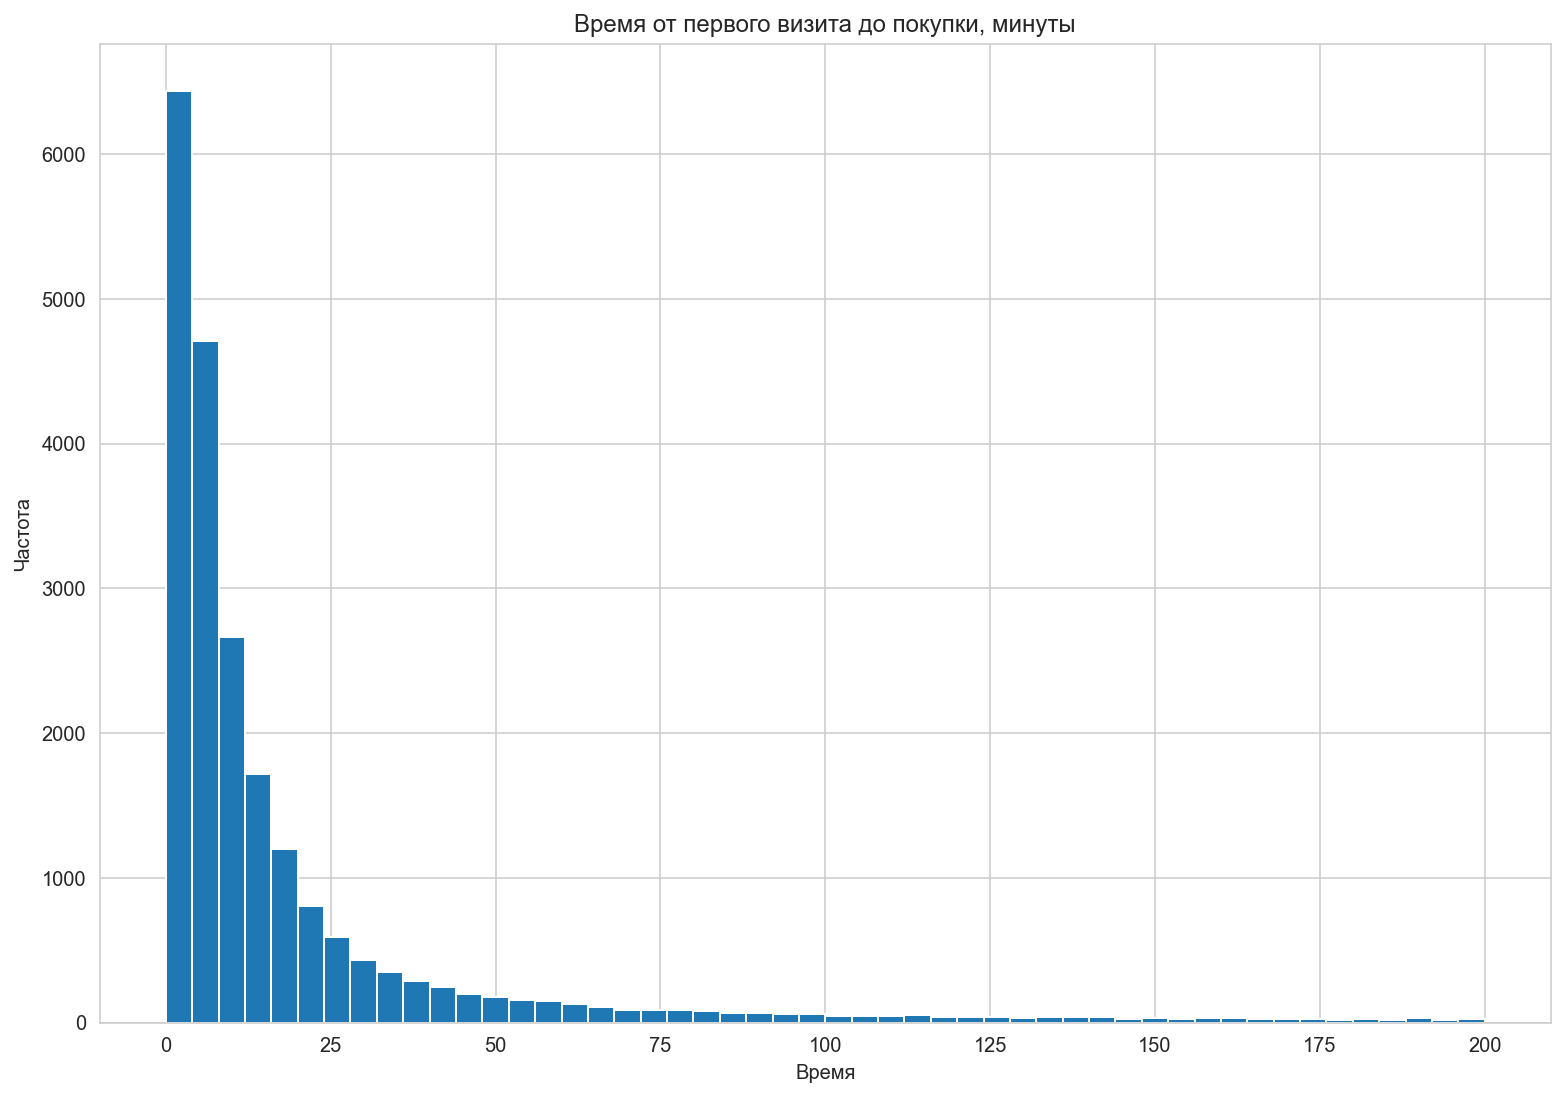

In [49]:
plt.figure(figsize = (13, 9))
df_purchase.query('time_to_purchase != 0')['time_to_purchase'].hist(bins=50, range=(0,200))
plt.title('Время от первого визита до покупки, минуты')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

#### Вывод:
В среднем, от первого визита до покупки проходит 16 минут. Если пользователь не совершил покупку в течение 25 минут, то вероятность покупки снижается.

#### <a name="purchase_by_period"></a> Количество покупок в день, неделю, месяц

In [50]:
# Добавим новые столбцы
df_orders_temp = df_orders.copy(deep=True)
df_orders_temp['purchase_date'] = df_orders_temp['buy_ts'].dt.date
df_orders_temp['purchase_week'] = df_orders_temp['buy_ts'].dt.week
df_orders_temp['purchase_month'] = df_orders_temp['buy_ts'].dt.month

In [51]:
# Найдем средние продажи за день, неделю и месяц
purchases_per_day = df_orders_temp.groupby('purchase_date').agg({'uid': 'count'}).mean()
purchases_per_week = df_orders_temp.groupby('purchase_week').agg({'uid': 'count'}).mean()
purchases_per_month = df_orders_temp.groupby('purchase_month').agg({'uid': 'count'}).mean()

print("Среднее количество продаж в день: {0:.2f}".format(purchases_per_day[0]))
print("Среднее количество продаж в неделю: {0:.2f}".format(purchases_per_week[0]))
print("Среднее количество продаж в месяц: {0:.2f}".format(purchases_per_month[0]))

Среднее количество продаж в день: 138.50
Среднее количество продаж в неделю: 969.52
Среднее количество продаж в месяц: 4201.25


#### Вывод:
Если выразить результаты продаж в виде доли от количества уникальных пользователей, то получим следующее:
- В день из 908 уникальных пользователей покупки совершают <b>15%</b>.
- В неделю из 5825 уникальных пользователей покупки совершают <b>17%</b>.
- В месяц из 23228 уникальных пользователей покупки совершают <b>18%</b>.

#### <a name="average_bill"></a> Средний чек

In [52]:
# Посмотрим на статистики дохода
df_orders['revenue'].describe()

count   50,415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max      2,633.28
Name: revenue, dtype: float64

In [53]:
# Найдем средний чек по месяцам
mean_revenue_by_month = df_orders_temp.groupby('purchase_month').agg({'revenue': 'mean'}).reset_index()

In [54]:
# Список месяцев для графика
month_list = ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь', 'Январь', 'Февраль', 'Март', 'Апрель','Май']

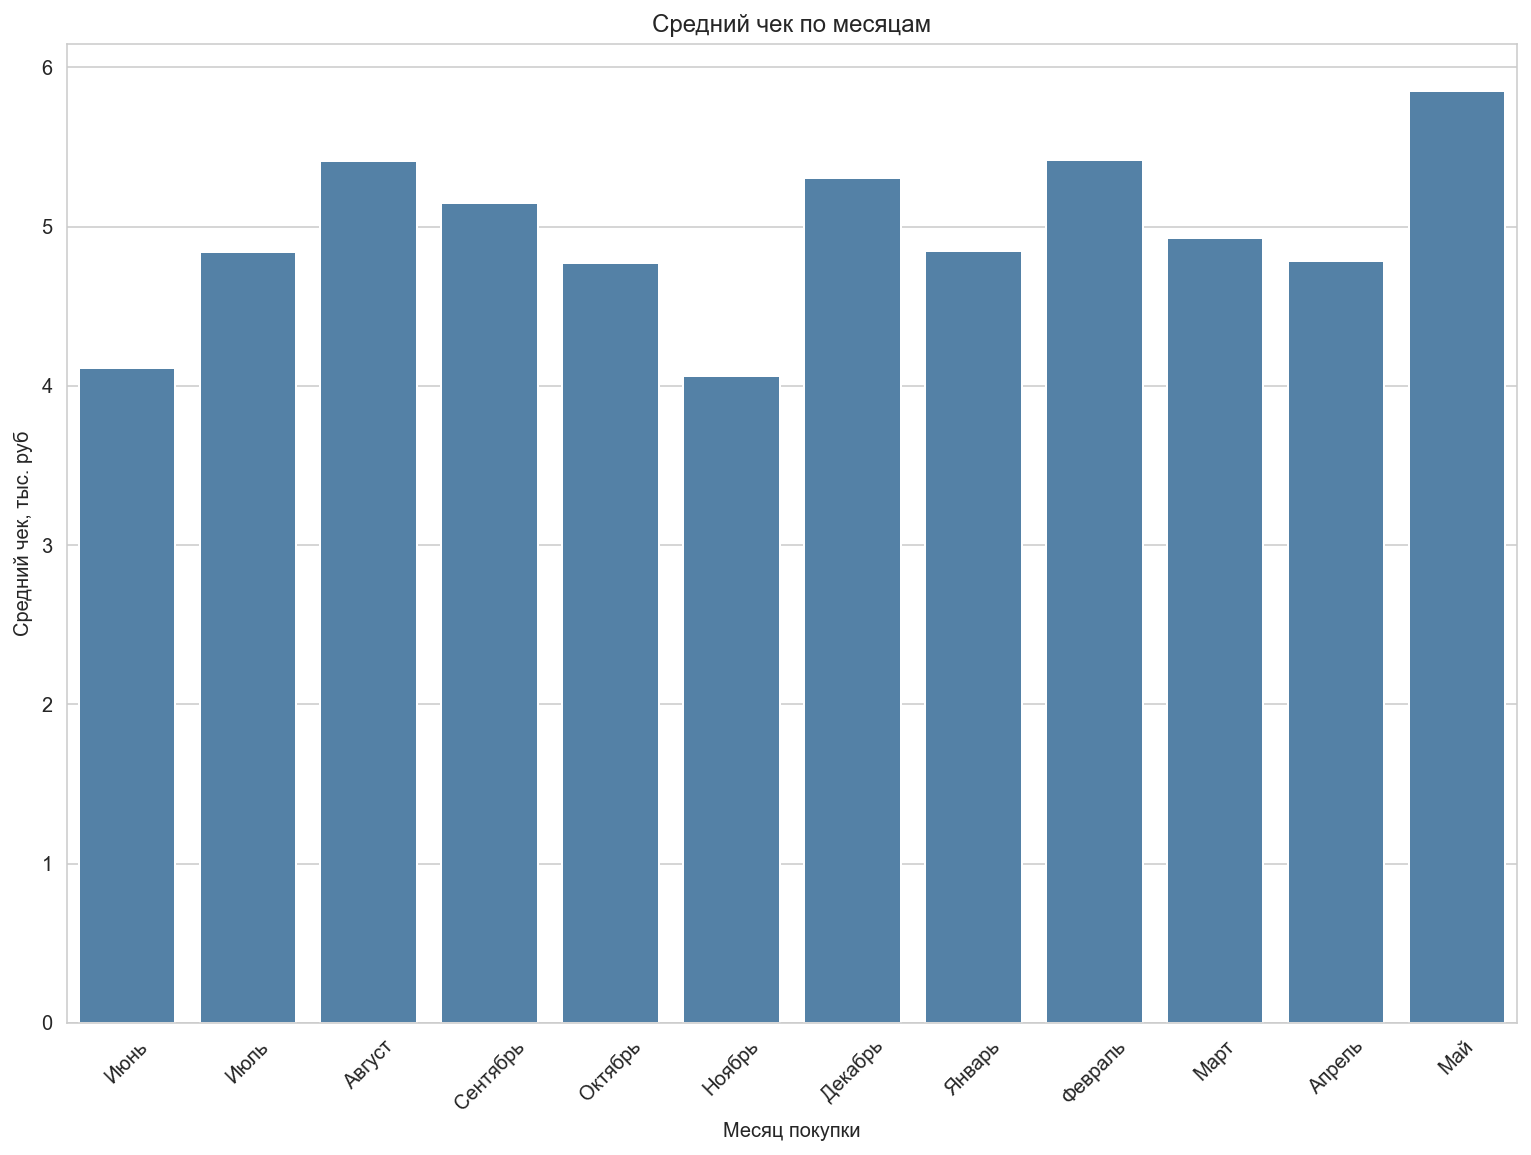

In [55]:
plt.figure(figsize = (13, 9))
plt.title('Средний чек по месяцам')
ax = sns.barplot(x="purchase_month", y="revenue", data=mean_revenue_by_month, color='steelblue')
ax.set_xticklabels(month_list, rotation=45)
plt.xlabel('Месяц покупки')
plt.ylabel('Средний чек, тыс. руб')
plt.show()

#### Вывод:
Средний чек - 5 тысяч рублей, самый высокий средний чек был в мае 2018 года - около 5.7 тысяч рублей.

#### <a name="ltv"></a> Livetime Value

In [56]:
# Создадим новые столбы в df_first_order и df_costs
df_orders['order_month'] =  df_orders['buy_ts'].astype('datetime64[M]') 
df_costs['month'] = df_costs['dt'].astype('datetime64[M]') 

In [57]:
# Найдем месяц первой покупки для каждого пользователя
df_first_orders = df_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
df_first_orders.columns = ['uid', 'first_order_month']

In [58]:
# Рассчитаем количество уникальных пользователей за каждый месяц
cohort_sizes = df_first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [59]:
# Добавим месяц первой покупки в датасет с заказами
df_orders_new = df_orders.merge(df_first_orders, on='uid')

# Сформируем когорты
cohorts = df_orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,"9,557.49"
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,"1,931.30"
4,2017-06-01,2017-10-01,"2,068.58"


In [60]:
# Добавим информацию о количестве уникальных пользователей
report = cohort_sizes.merge(cohorts, on='first_order_month')

# Найдем "возраст" когорты
report['age'] = ((report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

report.head()

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,"9,557.49",0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,"1,931.30",3
4,2017-06-01,2023,2017-10-01,"2,068.58",4


In [61]:
# Рассчитаем LTV
# Т.к. нам неизвестна маржинальность, рассчитаем просто по revenue
report['ltv'] = report['revenue'] / report['n_buyers']

In [62]:
# Построим сводную таблицу по когортам
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(2)

result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,nan
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,nan,nan
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,nan,nan,nan
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,nan,nan,nan,nan
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,nan,nan,nan,nan,nan
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,nan,nan,nan,nan,nan,nan
2018-01-01,4.14,0.29,0.30,0.14,0.06,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.16,0.28,0.08,0.07,nan,nan,nan,nan,nan,nan,nan,nan


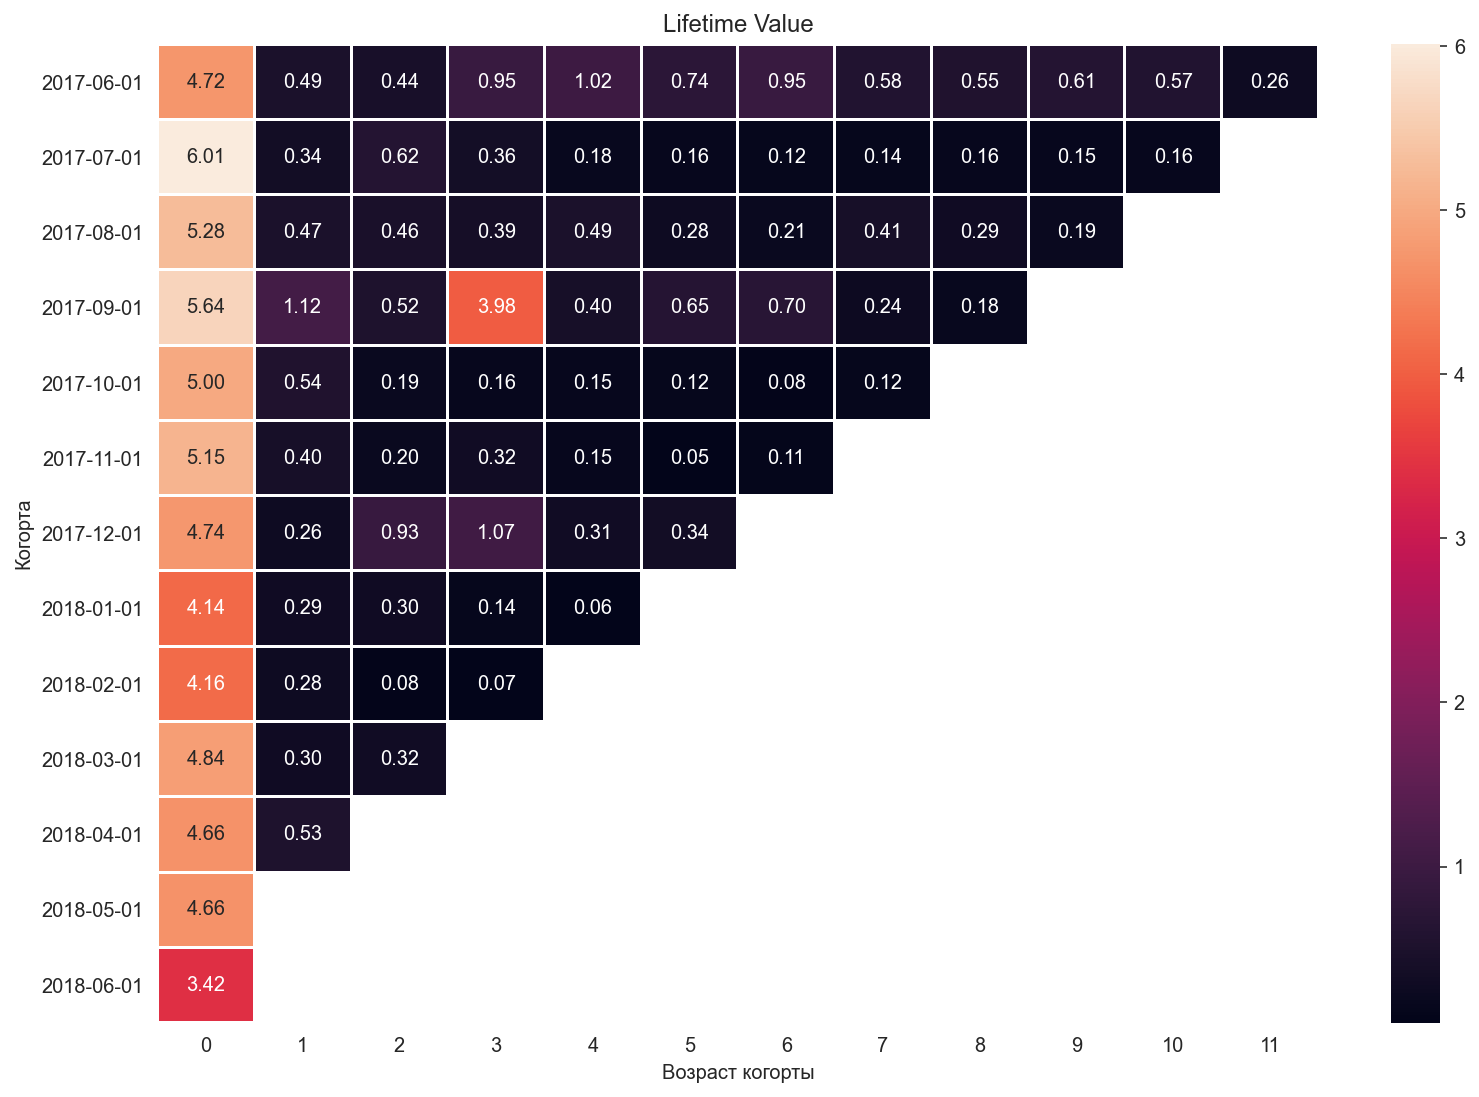

In [63]:
# Построим график heatmap
plt.figure(figsize = (13, 9))
plt.title('Lifetime Value')
ax = sns.heatmap(result, annot=True, fmt='.2f', linewidths=1, linecolor='white')
ax.set_yticklabels(result.index.date)
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

In [64]:
report.groupby('first_order_month').agg({'ltv':'sum'}).round(2).reset_index().sort_values(by='ltv')

,first_order_month,ltv
12,2018-06-01,3.42
8,2018-02-01,4.59
11,2018-05-01,4.66
7,2018-01-01,4.94
10,2018-04-01,5.19
9,2018-03-01,5.46
4,2017-10-01,6.36
5,2017-11-01,6.40
6,2017-12-01,7.64
1,2017-07-01,8.39


#### Вывод:
Самый высокий LTV у пользователей из когорт <b>2017-09-01</b>, <b>2017-06-01</b> и <b>2017-08-01</b>.

[Вернуться к оглавлению](#table_of_contents)

### <a name="marketing"></a> Маркетинговые метрики

#### В данном разделе исследования нужно ответить на следующие вопросы:
- Сколько денег потратили? Всего / на каждый источник / по времени?
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

#### <a name="costs_analysis"></a> Анализ маркетинговых расходов

In [65]:
# Суммарные расходы на маркетинг
total_costs = df_costs['costs'].sum()
print('Суммарные расходы на маркетинг составили: {0}'.format(total_costs))

Суммарные расходы на маркетинг составили: 329131.62


In [66]:
# Расходы по источникам
costs_by_source = df_costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()

# Рассчитаем долю каждого источника в общей сумме расходов
costs_by_source['ratio'] = (costs_by_source['costs'] / total_costs * 100).round(1)

costs_by_source.sort_values(by='ratio', ascending=False)

,source_id,costs,ratio
2,3,"141,321.63",42.90
3,4,"61,073.60",18.60
4,5,"51,757.10",15.70
1,2,"42,806.04",13.00
0,1,"20,833.27",6.30
6,10,"5,822.49",1.80
5,9,"5,517.49",1.70


In [67]:
# Расходы по месяцам
costs_by_month = df_costs.groupby('month').agg({'costs': 'sum'}).reset_index()

# Рассчитаем долю каждого месяца в общей сумме расходов
costs_by_month['ratio'] = (costs_by_month['costs'] / total_costs * 100).round(1)

costs_by_month = costs_by_month.sort_values(by='costs', ascending=False)
costs_by_month

,month,costs,ratio
6,2017-12-01,"38,315.35",11.60
5,2017-11-01,"37,907.88",11.50
4,2017-10-01,"36,322.88",11.00
7,2018-01-01,"33,518.52",10.20
8,2018-02-01,"32,723.03",9.90
9,2018-03-01,"30,415.27",9.20
3,2017-09-01,"24,368.91",7.40
10,2018-04-01,"22,289.38",6.80
11,2018-05-01,"22,224.27",6.80
1,2017-07-01,"18,240.59",5.50


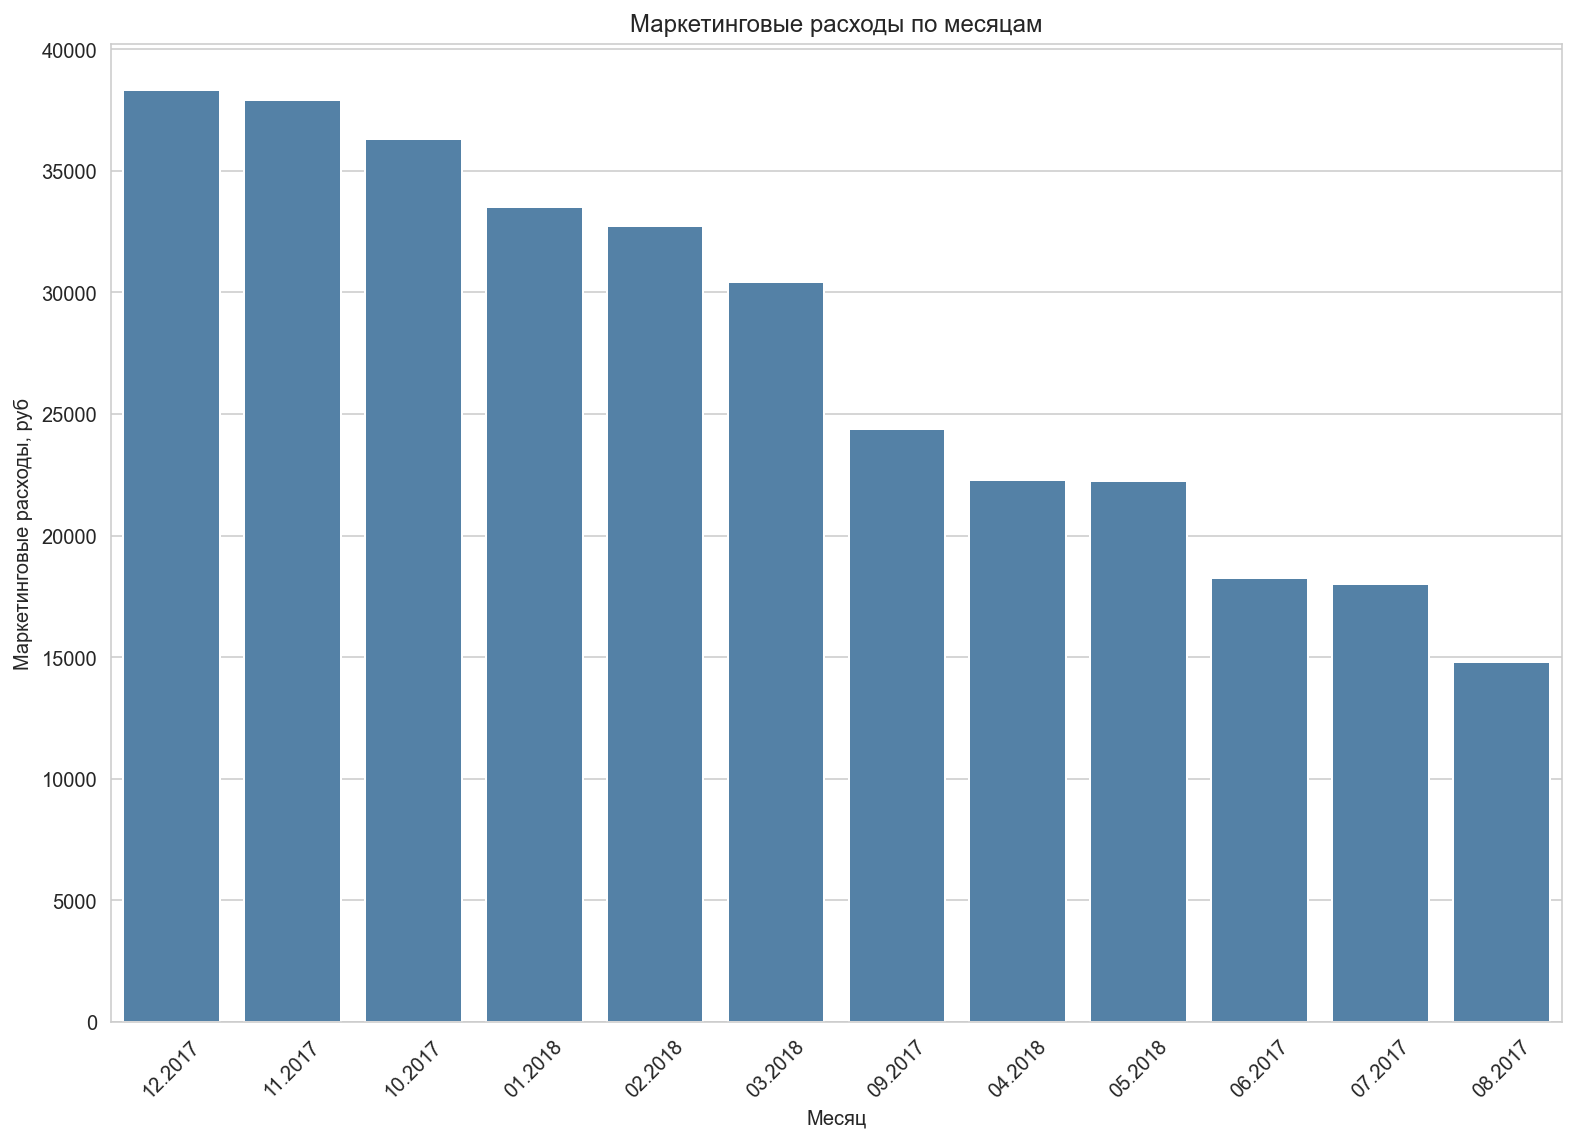

In [68]:
month_list = ['12.2017', '11.2017', '10.2017', '01.2018', '02.2018', '03.2018', '09.2017', '04.2018', '05.2018', '06.2017',
             '07.2017', '08.2017']

plt.figure(figsize = (13, 9))
plt.title('Маркетинговые расходы по месяцам')
ax = sns.barplot(x="month", y="costs", data=costs_by_month, color='steelblue')
ax.set_xticklabels(month_list, rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Маркетинговые расходы, руб')
plt.show()

#### Выводы:
1. Всего на маркетинг было потрачено <b>329 131.62 рублей</b>.
2. Больше всего было потрачено на источник <b>№3 - 42.9% всех расходов</b>. 
3. Самые высокие расходы на маркетинг в <b>декабре 2017 года</b>, при этом расходы в этом месяце составили 11.6% всех расходов.

#### <a name="cac"></a> Стоимость привлечения пользователей

In [69]:
# Сгруппируем визиты по источникам
# Выберем только записи, где первая дата сессии соответсвует первому визиту
visits_by_source = df_visits.query('start_ts == first_visit')[['source_id','uid']]

# Объединим таблицы, чтобы оставить только визиты, после которых пользователь совершил покупку
customers = df_orders.merge(visits_by_source, on='uid', how='inner')

# Сгруппируем данные
customers = customers.groupby('source_id').agg({'uid':'nunique'}).reset_index()

customers

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [70]:
# Подготовим данные для рассчёта CAC
# Добавим к таблице расходы по источникам
customers_and_costs = customers.merge(costs_by_source[['source_id', 'costs']], on='source_id')

customers_and_costs.sort_values(by='costs', ascending=False)

,source_id,uid,costs
2,3,10473,"141,321.63"
3,4,10296,"61,073.60"
4,5,6931,"51,757.10"
1,2,3506,"42,806.04"
0,1,2899,"20,833.27"
6,10,1329,"5,822.49"
5,9,1088,"5,517.49"


In [71]:
# Рассчитаем CAC
customers_and_costs['cac'] = (customers_and_costs['costs'] / customers_and_costs['uid']).round(1)
customers_and_costs.sort_values('cac', ascending = False)

,source_id,uid,costs,cac
2,3,10473,"141,321.63",13.50
1,2,3506,"42,806.04",12.20
4,5,6931,"51,757.10",7.50
0,1,2899,"20,833.27",7.20
3,4,10296,"61,073.60",5.90
5,9,1088,"5,517.49",5.10
6,10,1329,"5,822.49",4.40


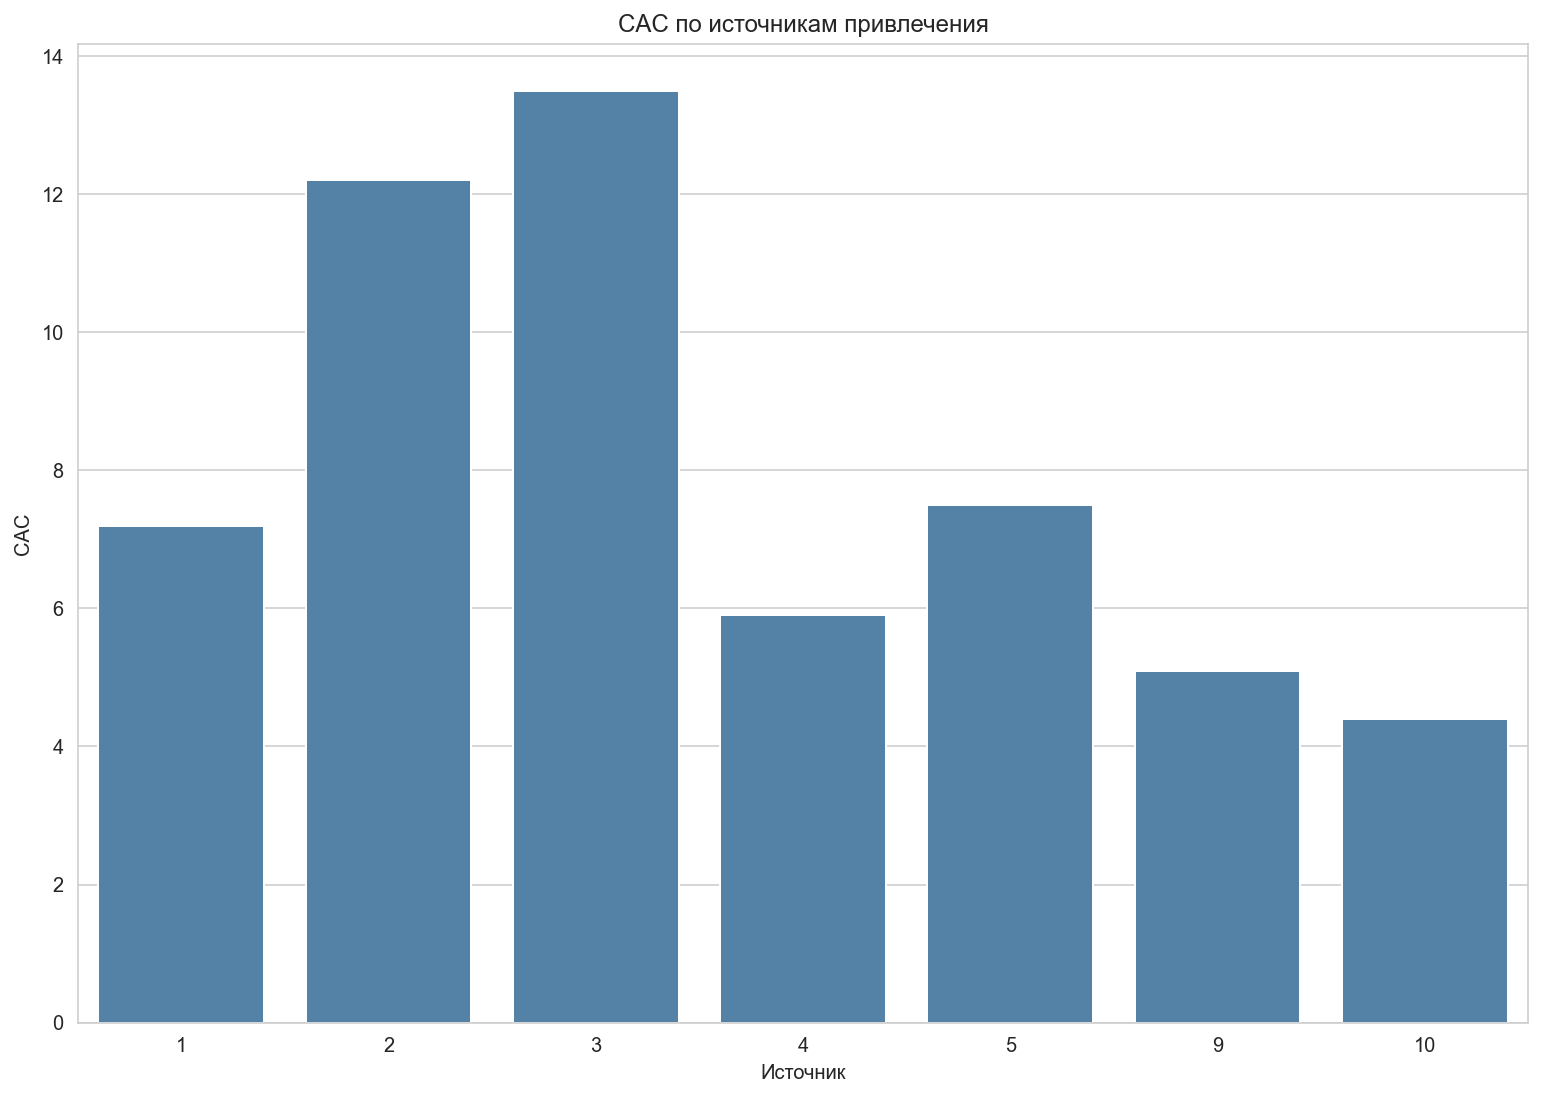

In [72]:
plt.figure(figsize = (13, 9))
plt.title('CAC по источникам привлечения')
ax = sns.barplot(x="source_id", y="cac", data=customers_and_costs, color='steelblue')
plt.xlabel('Источник')
plt.ylabel('CAC')
plt.show()

#### Выводы:
- Самый дорогой источник - №3.
- Самый дешевый источник - №10.

#### <a name="roi"></a> Коэффициент окупаемости

In [73]:
# Найдем доход по источникам
revenue_by_source = df_orders.merge(visits_by_source, on='uid', how='inner')

revenue_by_source = revenue_by_source.groupby('source_id').agg({'revenue':'sum'}).reset_index()

revenue_by_source

,source_id,revenue
0,1,"31,090.55"
1,2,"46,923.61"
2,3,"54,511.24"
3,4,"56,696.83"
4,5,"52,624.02"
5,7,1.22
6,9,"5,759.40"
7,10,"4,450.33"


In [74]:
# Рассчитаем ROI
roi = revenue_by_source.merge(costs_by_source[['source_id', 'costs']], on='source_id')
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

roi.sort_values(by='roi', ascending=False)

,source_id,revenue,costs,roi
0,1,"31,090.55","20,833.27",0.49
1,2,"46,923.61","42,806.04",0.10
5,9,"5,759.40","5,517.49",0.04
4,5,"52,624.02","51,757.10",0.02
3,4,"56,696.83","61,073.60",-0.07
6,10,"4,450.33","5,822.49",-0.24
2,3,"54,511.24","141,321.63",-0.61


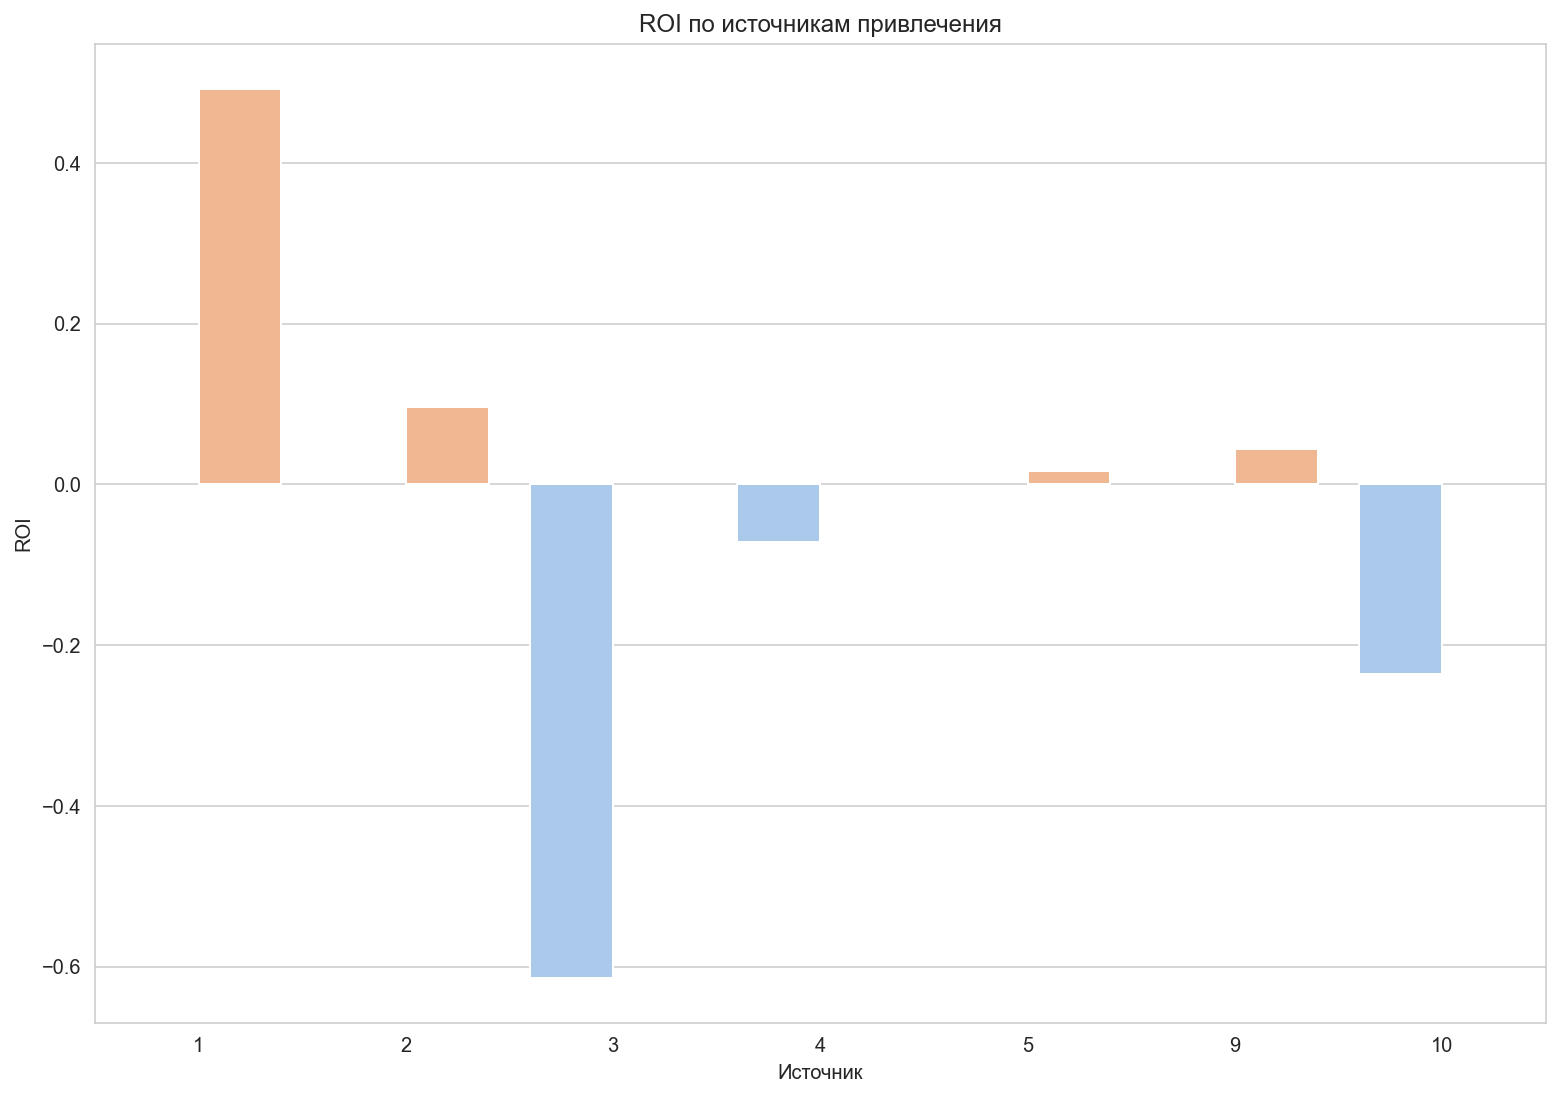

In [75]:
colors = [1 if roi >= 0 else 0 for roi in roi['roi']]  # Разный цвет столбцов в зависимости от значения
plt.figure(figsize = (13, 9))
plt.title('ROI по источникам привлечения')
ax = sns.barplot(x="source_id", y="roi", data=roi, hue=colors, palette='pastel')
ax.get_legend().remove()
plt.xlabel('Источник')
plt.ylabel('ROI')
plt.show()

#### Выводы:
- Самый высокий возврат инвестиций у источника №1.
- Самый низкий показатель у источника №3.

[Вернуться к оглавлению](#table_of_contents)

## <a name="conclusion"></a>Общий вывод

### <a name="what_was_done"></a> Обзор проведенного анализа
В ходе проведенного анализа были сделаны следующие шаги:
1. Произведена первичная оценка предоставленных данных.
2. Выполнена предобработка данных: названия столбцов приведены к нужному формату, типы данных приведены к необходимым для анализа.
3. Рассчитаны продуктовые метрики (DAU, WAU, MAU, количество и продолжительность сессий, Retention Rate).
4. Проведен анализ продаж (время от визита до покупки, количество покупок за разные периоды, средний чек, LTV).
5. Рассчитаны ROI и CAC.

### <a name="main_conclusions"></a> Главные выводы
1. Количество уникальных пользователей за день, неделю и месяц говорит о том, что продукт не слишком востребован у пользователей. Показатель Sticky Factor (вовлеченность пользователей) тоже довольно низкий.
2. В среднем, пользователь проводит одну сессию в день. Продолжительность сессии по моде - всего 60 секунд.
3. Начиная с 2 месяца для всех когорт снижается Retention Rate - пользователи не спешат возвращаться.
4. В среднем, от визита на сайт до покупки проходит 16 минут. После 25 минут резко снижается вероятность того, что покупка состоится.
5. Больше всего расходов на маркетинг связано с источником №3, но у этого источника самый низкий коэффициент окупаемости.
6. Большинство пользователей пользуются сервисом с помощью ПК.

### <a name="recommendations"></a> Рекомендации
В качестве рекомендаций, на основании проведенного анализа, предлагаю следующее:
1. Следует пересмотреть источники привлечения новых пользователей - источник №3 лидирует по количеству расходов, но у этого источника самая низкая окупаемость.
2. Источник №4 выглядит более интересным для инвестиций в маркетинг - из этого источника пришло больше всего уникальных пользователей и при текущем уровне CAC источник имеет положительный ROI.
3. Большинство пользователей взаимодействует с сервисом Яндекс.Афиша с помощью персональных компьютеров - возможно, при открытии с мобильных устройств сайт отображается некорректно. Следует проверить эту версию.

[Вернуться к оглавлению](#table_of_contents)